<a href="https://colab.research.google.com/github/abhinav-exp/Forecasting-CryptoCurrency-Prices/blob/master/MLP_with_JAYA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
GitHubDataLink = 'https://raw.githubusercontent.com/abhinav-exp/Forecasting-CryptoCurrency-Prices/master/Datasets/'
InputFileLink = GitHubDataLink + 'DataBTC2017.csv'
data1 = pd.read_csv(InputFileLink, header=0, index_col=0)
print(data1)

            CBBTCUSD
DATE                
2017-06-18   2515.25
2017-06-19   2596.98
2017-06-20   2725.08
2017-06-21   2643.35
2017-06-22   2679.99
...              ...
2019-08-03  10820.75
2019-08-04  10997.82
2019-08-05  11775.14
2019-08-06  11440.08
2019-08-07  12014.41

[781 rows x 1 columns]


In [ ]:
def split_sequence(sequence, n_steps):
  X= list()
  for i in range(len(sequence) - n_steps):
    end_ix = i + n_steps
    seq_x= sequence.values[i:end_ix, 0]
    X.append(seq_x)
  return pd.DataFrame(X)

data2 = split_sequence(data1, 10)
print(data2.shape)
print(data2)

(771, 10)
           0        1        2         3         4         5         6  \
0    2515.25  2596.98  2725.08   2643.35   2679.99   2690.76   2574.84   
1    2596.98  2725.08  2643.35   2679.99   2690.76   2574.84   2505.61   
2    2725.08  2643.35  2679.99   2690.76   2574.84   2505.61   2407.91   
3    2643.35  2679.99  2690.76   2574.84   2505.61   2407.91   2575.75   
4    2679.99  2690.76  2574.84   2505.61   2407.91   2575.75   2553.12   
..       ...      ...      ...       ...       ...       ...       ...   
766  9751.24  9880.67  9841.96   9468.92   9549.70   9503.32   9580.00   
767  9880.67  9841.96  9468.92   9549.70   9503.32   9580.00  10099.00   
768  9841.96  9468.92  9549.70   9503.32   9580.00  10099.00  10417.24   
769  9468.92  9549.70  9503.32   9580.00  10099.00  10417.24  10533.07   
770  9549.70  9503.32  9580.00  10099.00  10417.24  10533.07  10820.75   

            7         8         9  
0     2505.61   2407.91   2575.75  
1     2407.91   2575.75   255

In [90]:
train_x = data2.iloc[:int(0.85*len(data2)), :9]
train_y = data2.iloc[:int(0.85*len(data2)), 9:10]
test_x = data2.iloc[int(0.85*len(data2)):, :9]
test_y = data2.iloc[int(0.85*len(data2)):, 9:10]
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(655, 9)
(655, 1)
(116, 9)
(116, 1)


In [196]:
class JAYA_MLP():
  def __init__(self, p_size):
    self.p_size = p_size
    self.weights_layer1 = 2*np.random.random((p_size, 9, 100)) - 1
    self.weights_layer2 = 2*np.random.random((p_size, 100, 1)) - 1
    self.train_px = np.tile(np.expand_dims(train_x, axis = 0), (p_size, 1, 1))
    self.train_py = np.tile(np.expand_dims(train_y, axis = 0), (p_size, 1, 1))
    # print(train_y.shape)
    # print(self.train_py.shape)
    self.objectives = self.forward_propagation(self.weights_layer1, self.weights_layer2)
    self.best = np.argmin(self.objectives)
    self.worst = np.argmax(self.objectives)

  def forward_function(self, new_weights1, new_weights2, x):
    preds1 = np.matmul(x, new_weights1)
    preds1 = preds1 * (preds1 > 0)
    # print(preds1.shape)
    preds2 = np.matmul(preds1, new_weights2)
    preds2 = preds2 * (preds2 > 0)
    # print(preds2.shape)
    return preds2

  def forward_propagation(self, new_weights1, new_weights2):
    pred = self.forward_function(new_weights1, new_weights2, self.train_px)
    error = (pred - self.train_py)
    return np.mean(error ** 2, axis = 1)
    
  def optimise(self, gen):
    for _ in range(gen):
      print("gen "+str(_)+" ", end="")
      B1 = np.tile(self.weights_layer1[self.best], (self.p_size, 1, 1))
      W1 = np.tile(self.weights_layer1[self.worst], (self.p_size, 1, 1))
      B2 = np.tile(self.weights_layer2[self.best], (self.p_size, 1, 1))
      W2 = np.tile(self.weights_layer2[self.worst], (self.p_size, 1, 1))
      rb = np.random.random((self.p_size, 1, 1))
      rw = np.random.random((self.p_size, 1, 1))
      new_w1 = self.weights_layer1 
      new_w1 += np.tile(rb, (1, 9, 100))*(B1 - (self.weights_layer1))
      new_w1 -= np.tile(rw, (1, 9, 100))*(W1 - (self.weights_layer1))
      new_w2 = self.weights_layer2 
      new_w2 += np.tile(rb, (1, 100, 1))*(B2 - (self.weights_layer2))
      new_w2 -= np.tile(rw, (1, 100, 1))*(W2 - (self.weights_layer2))
      new_obj = self.forward_propagation(new_w1, new_w2)
      cond = new_obj < self.objectives
      # print(cond[:, 0])
      self.weights_layer1 = np.where(np.tile(np.expand_dims(cond, axis = 2), (1, 9, 100)), new_w1, self.weights_layer1)
      self.weights_layer2 = np.where(np.tile(np.expand_dims(cond, axis = 2), (1, 100, 1)), new_w2, self.weights_layer2)
      self.objectives = np.where(cond, new_obj, self.objectives)
      self.best = np.argmin(self.objectives)
      self.worst = np.argmax(self.objectives)
      print("\t", end="")
      print(self.objectives[self.best, 0], end="")
      print("\t", end="")
      print(self.objectives[self.worst, 0])
      # break

In [219]:
optimiser = JAYA_MLP(100)
# optimiser.func_x(train_x).shape
optimiser.objectives
optimiser.optimise(100)

gen 0 	5225124.592422987	7253831114.23091
gen 1 	5225124.592422987	5045716255.176077
gen 2 	5225124.592422987	54556619.63680641
gen 3 	5225124.592422987	54556619.63680641
gen 4 	5225124.592422987	54556619.63680641
gen 5 	5225124.592422987	54556619.63680641
gen 6 	5225124.592422987	54556619.63680641
gen 7 	5225124.592422987	54556619.63680641
gen 8 	5225124.592422987	54556619.63680641
gen 9 	5225124.592422987	54556619.63680641
gen 10 	5225124.592422987	54556619.63680641
gen 11 	5225124.592422987	54556619.63680641
gen 12 	5225124.592422987	54556619.63680641
gen 13 	5225124.592422987	54556619.63680641
gen 14 	5225124.592422987	54556619.63680641
gen 15 	5225124.592422987	54556619.63680641
gen 16 	5225124.592422987	54556619.63680641
gen 17 	5225124.592422987	54556619.63680641
gen 18 	5225124.592422987	54556619.63680641
gen 19 	5225124.592422987	54556619.63680641
gen 20 	5225124.592422987	54556619.63680641
gen 21 	5225124.592422987	54556619.63680641
gen 22 	5225124.592422987	54556619.63680641

In [211]:
preds = optimiser.forward_function(optimiser.weights_layer1[optimiser.best], optimiser.weights_layer2[optimiser.best], test_x)

In [212]:
preds

,0
655,382592.880246
656,383152.455061
657,409489.230368
658,372055.773758
659,411234.833338
...,...
766,821139.654653
767,807308.995238
768,822025.778191
769,862003.272743


In [213]:
test_y

,9
655,5066.22
656,5164.27
657,5029.99
658,5202.90
659,5227.00
...,...
766,10533.07
767,10820.75
768,10997.82
769,11775.14


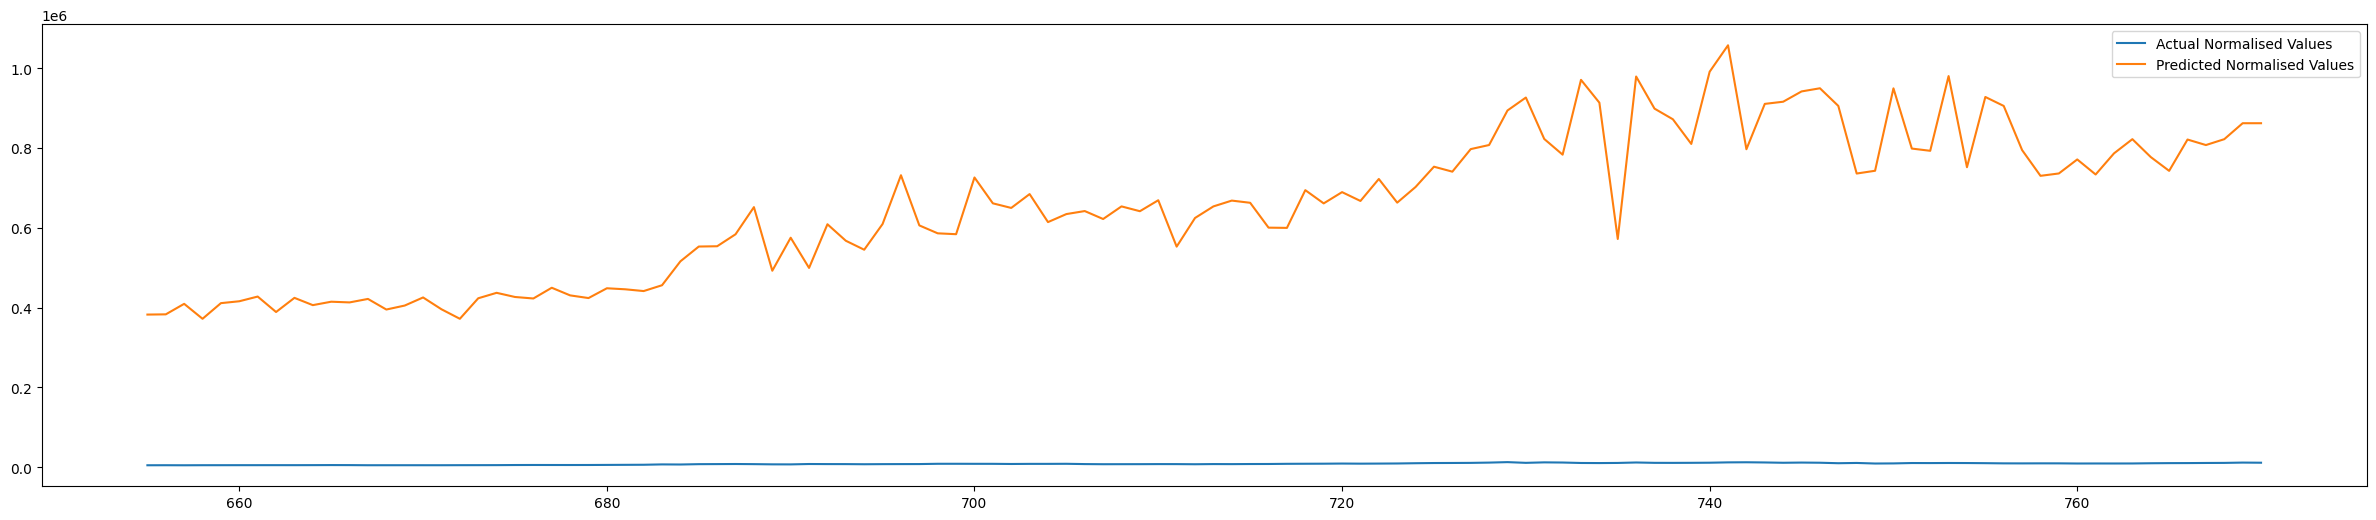

In [214]:
plt.figure(figsize=(30, 6))
plt.plot(test_y[9])
plt.plot(preds)
plt.legend(["Actual Normalised Values", "Predicted Normalised Values"])
plt.show()

In [215]:
preds1 = pd.DataFrame(preds)
preds1['DATE'] = data1.index[-1*len(preds):]
preds1 = preds1.set_index('DATE')
print(preds1)

                        0
DATE                     
2019-04-14  382592.880246
2019-04-15  383152.455061
2019-04-16  409489.230368
2019-04-17  372055.773758
2019-04-18  411234.833338
...                   ...
2019-08-03  821139.654653
2019-08-04  807308.995238
2019-08-05  822025.778191
2019-08-06  862003.272743
2019-08-07  862006.867922

[116 rows x 1 columns]


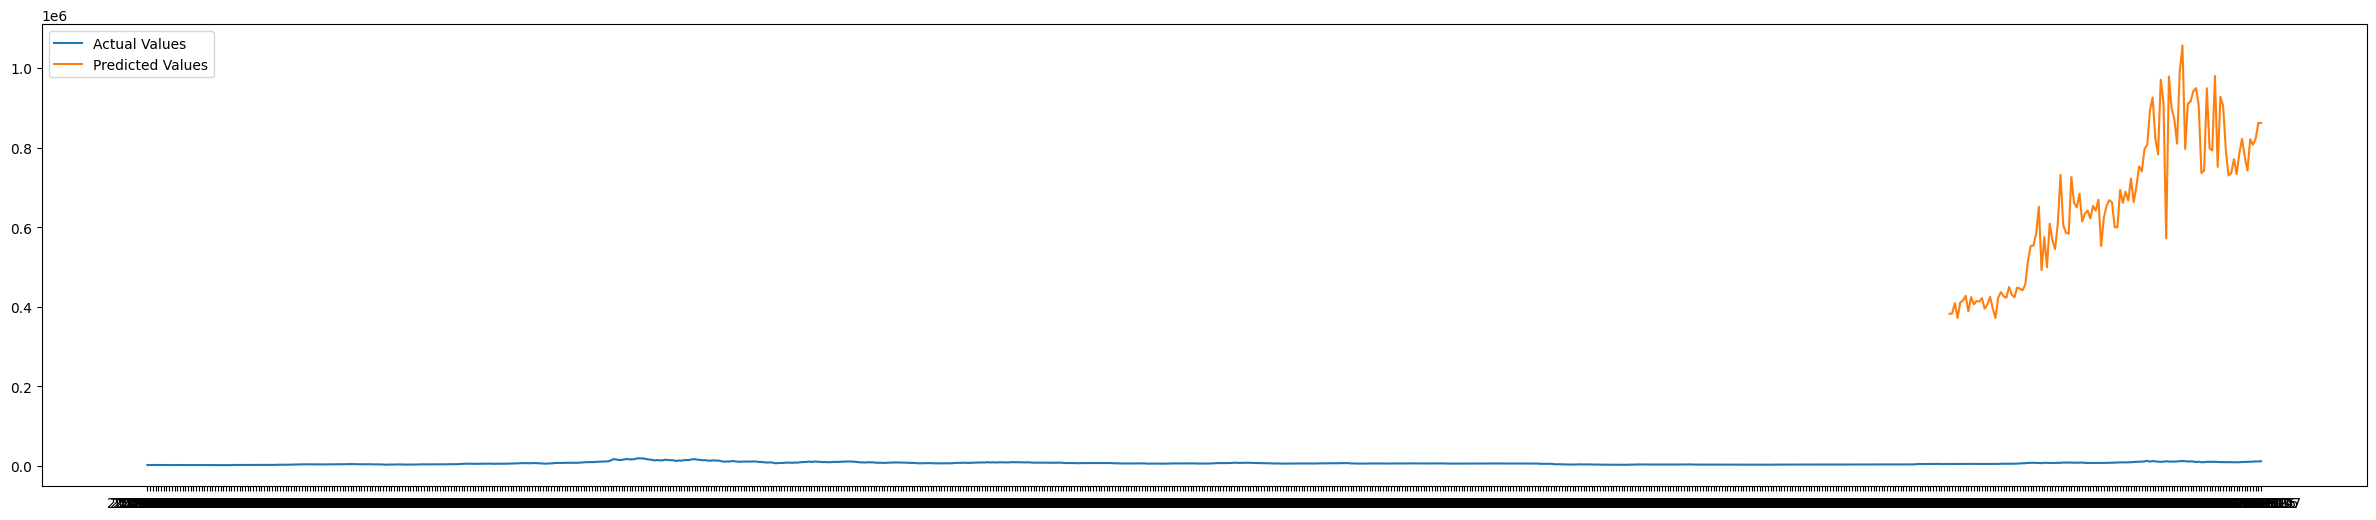

In [216]:
plt.figure(figsize=(30, 6))
plt.plot(data1)
plt.plot(preds1)
plt.legend(["Actual Values", "Predicted Values"])
plt.show()

In [217]:
mse = np.mean((np.array(preds1[0]) - np.array(data1.iloc[-1*(len(preds1)):, 0]))**2)
print("mse  "+ str(mse))
print("rmse "+ str(np.sqrt(mse)))
mae = np.mean(np.abs(np.array(preds1[0]) - np.array(data1.iloc[-1*(len(preds1)):, 0])))
print("mae  "+ str(mae))
mape = np.mean(np.abs(np.array(preds1[0]) - np.array(data1.iloc[-1*(len(preds1)):, 0]))/ np.array(data1.iloc[-1*(len(preds1)):, 0]))
print("mape "+ str(mape))

mse  454224297508.017
rmse 673961.6439442359
mae  649589.068895001
mape 75.00986819025212
